## COVID-19 Image Recognition Pretrained Models - First Run

###Introduction
###VGG16
###ResNet50
###DenseNet169
###InceptionResNetV2
###InceptionV3


### Introduction

In the first phase of this project, we created an initial model that achieved over 90% accuracy in just 15 epochs. In this next phase, we'll be testing several pretrained models - DenseNet169, InceptionV3, ResNet50, VGG16, and InceptionResNetV2 - in hopes that at least one of them can achieve a higher accuracy than our inital model. In a separate notebook, we'll complete the project by tuning the strongest of these models.  

A little background in case you haven't viewed the notebook containing the inital model:

This project is influenced by Thomas Mann's *The Magic Mountain*, in which protagonist Hans Castorp spends seven years at a sanatorium that treats tuberculosis patients in the early part of the 20th century. Mann describes the chest x-ray images of patients in great detail, with Dr. Behrens explaining to Hans Castorp which telltale signs in the images indicate tuberculosis. 

While tuberculosis is still a significant ailment in many parts of the world, this project is concerned with a more topical disease - COVID-19. While there are several tests available to test for COVID-19, x-ray imaging still plays a vital role in understanding the damage that COVID can wreak on a patient's lungs.  

COVID can cause patients to develop pneumonia. There is a great deal of research being done to determine how COVID based pnuemonia differs from non-COVID pnuemonia. While COVID and non-COVID pneumonias are both viral, there are some distinguishing features of the COVID variety, including a ground glass appearance on CT scans and that it affects both lungs rather than just one (non-COVID pneumonias can also effect both lungs, but less consistently). 

This project will attempt to train a model to distinuish among the lungs of COVID, viral (non-COVID) pneumonia, and healthy patients (or at least those that don't have either type of pneumonia). 

We'll be working with over 3800 images collected from a variety of sources, all of which can be found here:
https://www.kaggle.com/tawsifurrahman/covid19-radiography-database



As we did previously, let's begin by loading any libraries we may need, including tensorflow, keras, pandas, numpy, and matplotlib.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Add a couple of random seeds to make our outcomes more consistent.

In [ ]:
# Random seeds from both numpy and tensorflow
from numpy.random import seed
seed(99)
tf.random.set_seed(99)   

Since this is being done on Colab, we'll mount the images from Google Drive. There are other ways to also load the images, depending on which application you're using.

In [ ]:
# Mount Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


As a reminder, the following sets of images are chest x-rays of COVID patients, followed by pneumonia and healthy (labeled as NORMAL) patients.

Display random COVID patient images


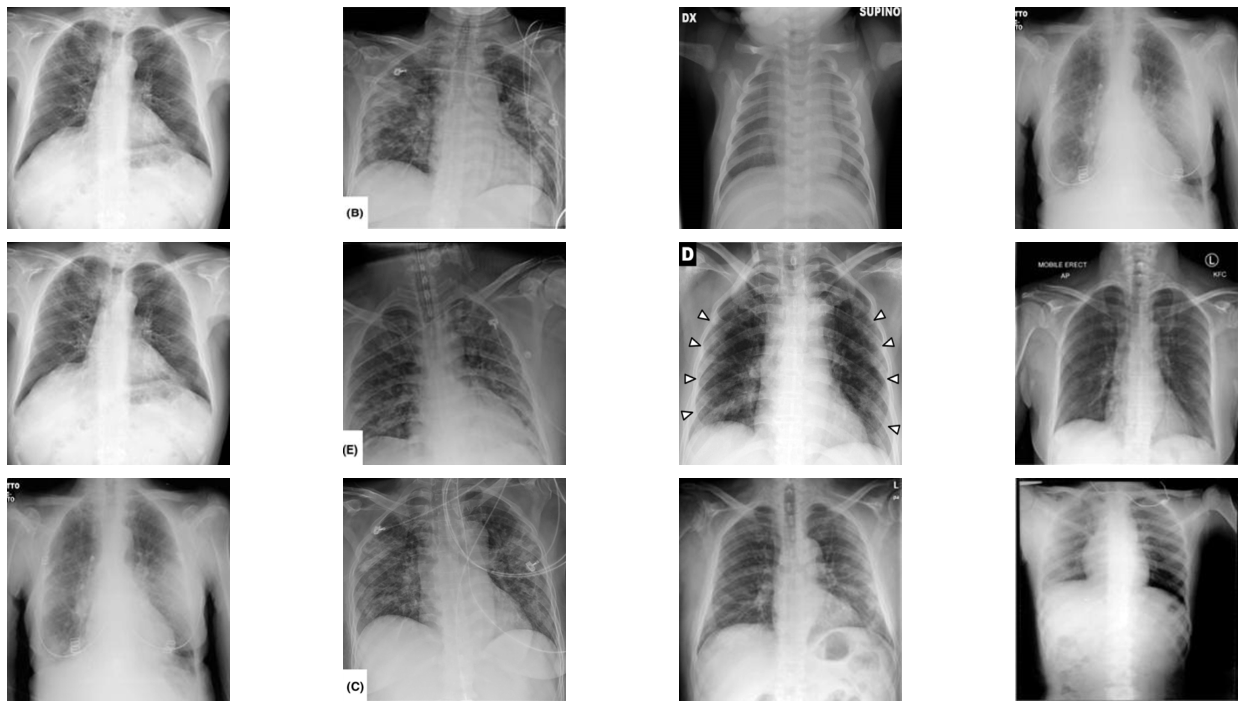

In [ ]:
# Location of images
path = "/content/drive/MyDrive/COVID-19 Radiography Database/train/COVID"
image_files = os.listdir(path)


print('Display random COVID patient images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Select and display random images
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(path, image_files[random.randrange(0, len(image_files))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

Display random viral pneumonia patient images


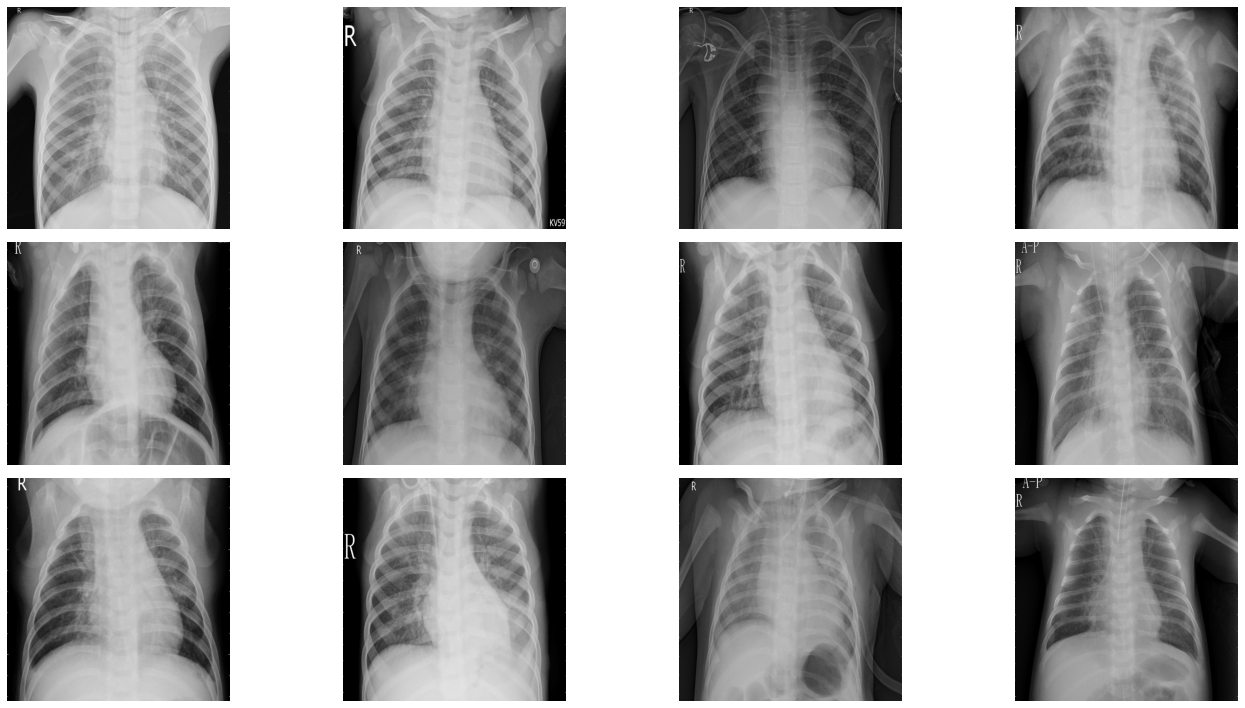

In [ ]:
# Location of images
path = "/content/drive/MyDrive/COVID-19 Radiography Database/train/Viral Pneumonia"
image_files = os.listdir(path)


print('Display random viral pneumonia patient images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Select and display random images
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(path, image_files[random.randrange(0, len(image_files))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

Display random normal patient images


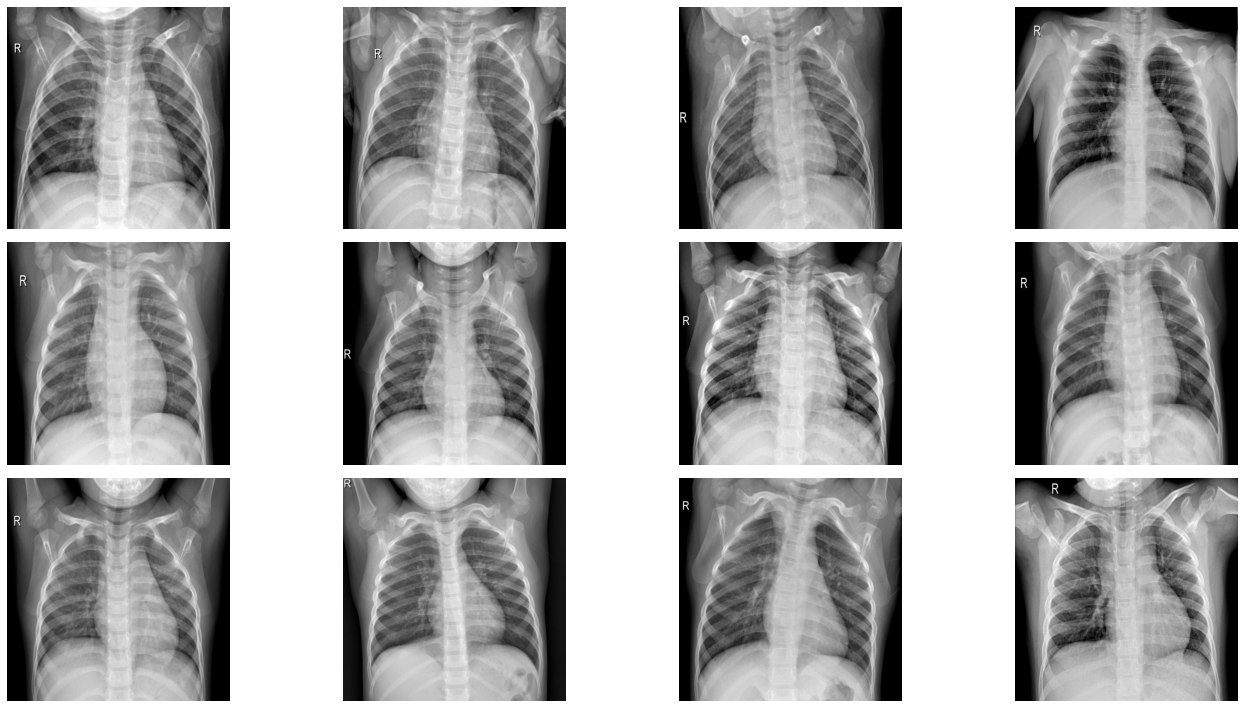

In [ ]:
# Location of images
path = "/content/drive/MyDrive/COVID-19 Radiography Database/train/NORMAL"
image_files = os.listdir(path)


print('Display random normal patient images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Select and display random images
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(path, image_files[random.randrange(0, len(image_files))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

As we can see, there are some similarities between the COVID and pneumonia patients, particularly with regard to the cloudy appearance of the scans. However, the COVID patients on average seem to have the cloudiest images, while the healthy patients have the clearest.

In [ ]:
# Import ImageDataGenerator to allow us to create batches and perform data augmentation
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Rescale the images
train_data_generator = ImageDataGenerator(rescale=1./255)
valid_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
# Paths to access the correct image folders
train_path = '/content/drive/MyDrive/COVID-19 Radiography Database/train'
valid_path = '/content/drive/MyDrive/COVID-19 Radiography Database/validation'
test_path = '/content/drive/MyDrive/COVID-19 Radiography Database/test'

We'll now use image generator to define where our train, validation, and test images are found as well as to dictate image size and batch size. The orignal images size is 256 x 256, most of our pretrained models work with 224 x 224 images. We're running a 60/20/20 split (train/validation/test).  

In [ ]:
train_batches = train_data_generator.flow_from_directory(train_path, 
                                                                   target_size=(224, 224), 
                                                                   classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                                   batch_size=32)
valid_batches = valid_data_generator.flow_from_directory(valid_path, 
                                                        target_size=(224, 224), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

test_batches = test_data_generator.flow_from_directory(test_path, 
                                                        target_size=(224, 224), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

Found 2335 images belonging to 3 classes.
Found 776 images belonging to 3 classes.
Found 775 images belonging to 3 classes.


In [ ]:
# Function to graph training and validation accuracy/loss results
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.figure(figsize=(15, 7))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.title('Training and validation')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

We'll now begin training our pretrained models, starting with VGG16. For the sake of consistency,  we'll add all of the same additional layers - a flattening layer, a dense layer with ReLu activation, and, finally, a dense layer with Softmax activation. We'll also use an Adam optimizer with a 0.01 learning rate and categorical crossentropy loss.  

Additionally, we'll be using the ModelCheckpoint callback because, one, we're anticipating inconsistency among epochs, and, two, due to the large number of models we're testing, we're using a small number of epochs per model. Performance can be a bit erratic during the first few epochs. Using ModelCheckpoint will allow us to save the weights of the epoch with the lowest validation loss, which we'll then apply to our test set. 

###VGG16

In [ ]:
# Load the model
vgg16 = tf.keras.applications.VGG16(
                  include_top=False,
                  input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
#Adjust several layers
model_vgg = tf.keras.Sequential()
model_vgg.add(vgg16)
model_vgg.add(tf.keras.layers.Flatten())
model_vgg.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# fit/train the model using the images and labels

%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='vgg16.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model_vgg.fit(train_batches, 
                    steps_per_epoch=73, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=25, 
                    epochs=15, 
                    verbose = 1)

Epoch 1/15
73/73 [==============================] - 1229s 16s/step - loss: 2.1095 - accuracy: 0.3743 - val_loss: 0.7385 - val_accuracy: 0.7397

Epoch 00001: val_loss improved from inf to 0.73852, saving model to vgg16.h5
Epoch 2/15
73/73 [==============================] - 45s 611ms/step - loss: 0.6515 - accuracy: 0.7229 - val_loss: 0.3599 - val_accuracy: 0.8673

Epoch 00002: val_loss improved from 0.73852 to 0.35994, saving model to vgg16.h5
Epoch 3/15
73/73 [==============================] - 45s 608ms/step - loss: 0.2808 - accuracy: 0.8968 - val_loss: 0.4359 - val_accuracy: 0.8170

Epoch 00003: val_loss did not improve from 0.35994
Epoch 4/15
73/73 [==============================] - 44s 607ms/step - loss: 0.2634 - accuracy: 0.8989 - val_loss: 0.3048 - val_accuracy: 0.9098

Epoch 00004: val_loss improved from 0.35994 to 0.30485, saving model to vgg16.h5
Epoch 5/15
73/73 [==============================] - 45s 609ms/step - loss: 0.1692 - accuracy: 0.9409 - val_loss: 0.2608 - val_accuracy

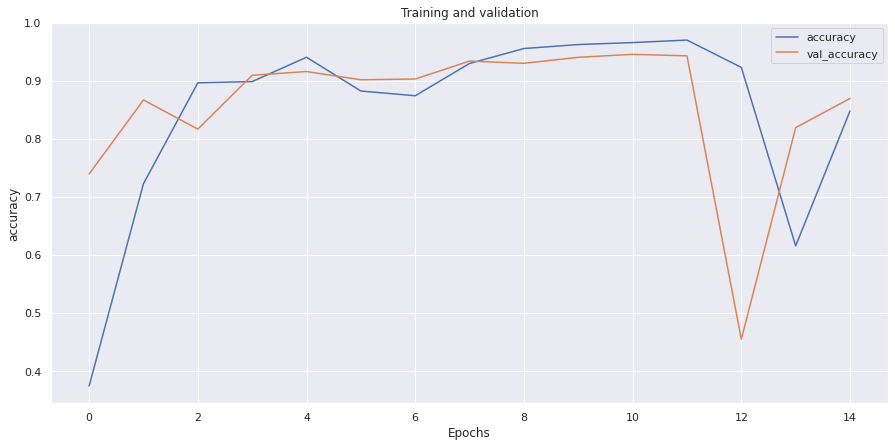

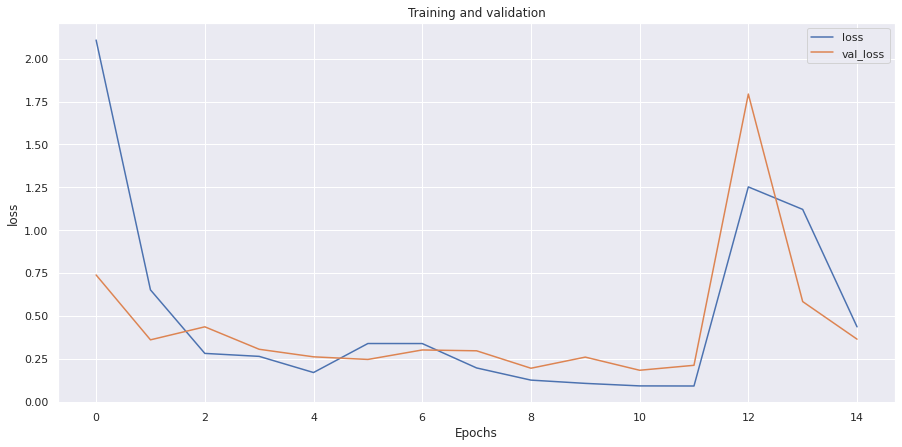

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_vgg.save("vgg16.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
vgg16_model = load_model('vgg16.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = vgg16_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 302s 13s/step - loss: 0.3576 - accuracy: 0.8903
test loss: 0.35763871669769287
test acc: 0.8903225660324097


This performed reasonably well, but it's still lower than the accuracy of our inital model. We'll keep it under consideration for now, but we may likely drop it if other models perform better. 

Let's move onto ResNet50.

###Resnet50

In [ ]:
# Load the ResNet50 model
#from keras.applications import ResNet50

rn50 = tf.keras.applications.ResNet50(
                  include_top=False,
                  input_shape=(224, 224, 3))

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
#Adjust several layers
model_rn = tf.keras.Sequential()
model_rn.add(rn50)
model_rn.add(tf.keras.layers.Flatten())
model_rn.add(tf.keras.layers.Dense(256, activation='relu'))
model_rn.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_rn.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# fit/train the model using the images and labels

%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='rn50.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model_rn.fit(train_batches, 
                    steps_per_epoch=73, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=25, 
                    epochs=15, 
                    verbose = 1)

Epoch 1/15
73/73 [==============================] - 53s 633ms/step - loss: 1.9563 - accuracy: 0.8912 - val_loss: 3136906.2500 - val_accuracy: 0.3093

Epoch 00001: val_loss improved from inf to 3136906.25000, saving model to rn50.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
73/73 [==============================] - 44s 596ms/step - loss: 0.1099 - accuracy: 0.9636 - val_loss: 7387.7422 - val_accuracy: 0.3093

Epoch 00002: val_loss improved from 3136906.25000 to 7387.74219, saving model to rn50.h5
Epoch 3/15
73/73 [==============================] - 44s 597ms/step - loss: 5.5386 - accuracy: 0.8660 - val_loss: 9075658.0000 - val_accuracy: 0.3093

Epoch 00003: val_loss did not improve from 7387.74219
Epoch 4/15
73/73 [==============================] - 44s 596ms/step - loss: 0.5113 - accuracy: 0.8732 - val_loss: 1.5435 - val_accuracy: 0.3466

Epoch 00004: val_loss improved from 7387.74219 to 1.54350, saving model to rn50.h5
Epoch 5/15
73/73 [==============================] - 44s 595ms/step - loss: 0.2020 - accuracy: 0.9319 - val_loss: 3.3398 - val_accuracy: 0.3093

Epoch 00005: val_loss did not improve from 1.54350
Epoch 6/15
73/73 [==============================] - 44s 603ms/step - loss: 0.1505 - accuracy: 0.9452 - val_loss: 4.5541 - val_accuracy: 0.

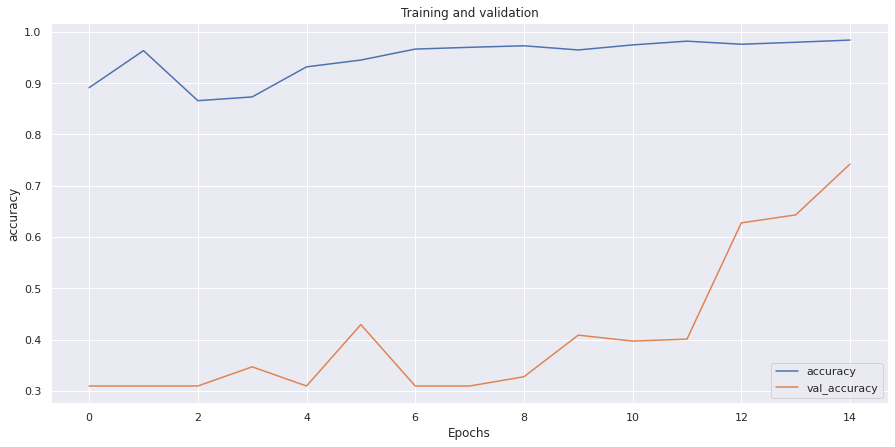

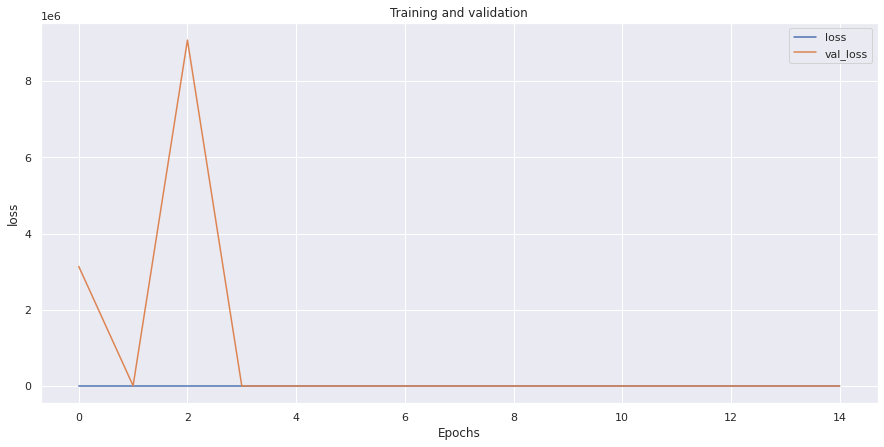

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_rn.save("rn50.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
rn50_model = load_model('rn50.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = rn50_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 12s 457ms/step - loss: 1.1679 - accuracy: 0.7058
test loss: 1.1678555011749268
test acc: 0.7058064341545105


While ResNet50's training accuracy was very high, it performed poorly on the validation set as well as the test set, suggesting a high degree of overfitting. Given that we already have two models thusfar that have performed much better (including the inital model), we'll drop ResNet50 because it doesn't seem worth the effort to tune it.

###DenseNet169

Next up, DenseNet169.

In [ ]:
# Include several callbacks
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger

tensorflow.python.keras.callbacks.CSVLogger

In [ ]:
dn1692 = tf.keras.applications.DenseNet169(
                  include_top=False,
                  input_shape=(224, 224, 3))

51879936/51877672 [==============================] - 1s 0us/step


In [ ]:
model_dn = tf.keras.Sequential()
model_dn.add(dn1692)
model_dn.add(tf.keras.layers.Flatten())
model_dn.add(tf.keras.layers.Dense(256, activation='relu'))
model_dn.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_dn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='dn1692.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model_dn.fit(train_batches, 
                    steps_per_epoch=73, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=25, 
                    epochs=15, 
                    verbose = 1)

Epoch 1/15
73/73 [==============================] - 65s 711ms/step - loss: 4.9365 - accuracy: 0.7596 - val_loss: 200642272.0000 - val_accuracy: 0.3093

Epoch 00001: val_loss improved from inf to 200642272.00000, saving model to dn1692.h5
Epoch 2/15
73/73 [==============================] - 47s 638ms/step - loss: 3.0044 - accuracy: 0.8518 - val_loss: 9346.8857 - val_accuracy: 0.3338

Epoch 00002: val_loss improved from 200642272.00000 to 9346.88574, saving model to dn1692.h5
Epoch 3/15
73/73 [==============================] - 47s 642ms/step - loss: 2.5461 - accuracy: 0.8611 - val_loss: 580551.4375 - val_accuracy: 0.5619

Epoch 00003: val_loss did not improve from 9346.88574
Epoch 4/15
73/73 [==============================] - 47s 635ms/step - loss: 0.8253 - accuracy: 0.9111 - val_loss: 634.6720 - val_accuracy: 0.4034

Epoch 00004: val_loss improved from 9346.88574 to 634.67200, saving model to dn1692.h5
Epoch 5/15
73/73 [==============================] - 47s 634ms/step - loss: 0.4864 - ac

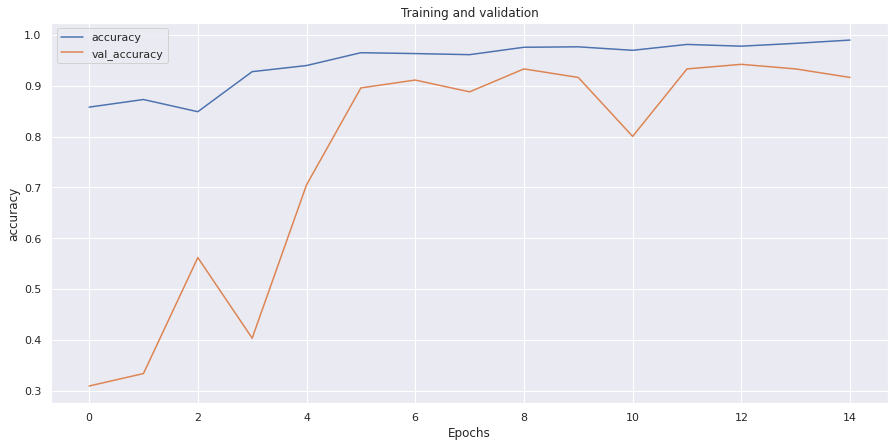

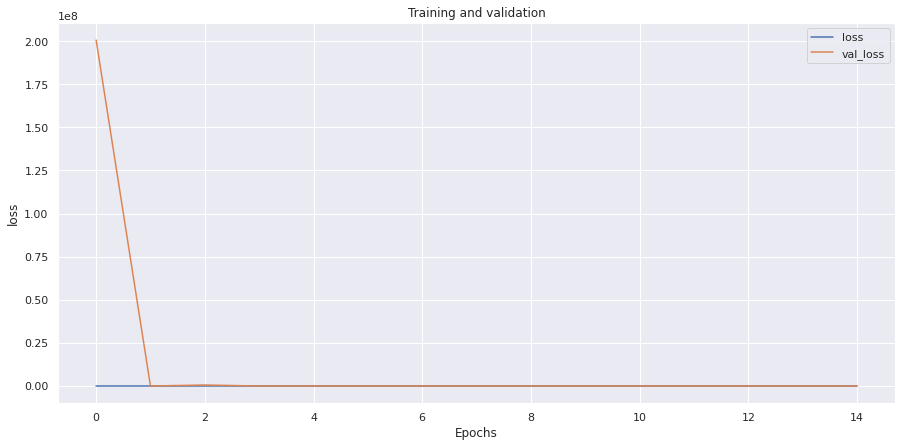

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_dn.save("dn1692.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
dn1692_model = load_model('dn1692.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = dn1692_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 14s 446ms/step - loss: 0.6259 - accuracy: 0.8710
test loss: 0.625934362411499
test acc: 0.8709677457809448


While better than ResNet50, it still considerably lower than the accuracy of our inital model. So, we'll drop DenseNet169 as well.

###InceptionResNetV2

As a late edition to this notebook, we'll also consider InceptionResnetV2 due to its high level of accuracy compared to many of the models tested above. However, before we can begin training, we need to change the size of our images because this particular model has a default image size of 299 x 299 rather than 224 x 224. 

In [ ]:
train_batches_irnv2 = train_data_generator.flow_from_directory(train_path, 
                                                                   target_size=(299, 299), 
                                                                   classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                                   batch_size=32)
valid_batches_irnv2 = valid_data_generator.flow_from_directory(valid_path, 
                                                        target_size=(299, 299), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

test_batches_irnv2 = test_data_generator.flow_from_directory(test_path, 
                                                        target_size=(299, 299), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

Found 2335 images belonging to 3 classes.
Found 776 images belonging to 3 classes.
Found 775 images belonging to 3 classes.


In [ ]:
irnv2 = tf.keras.applications.InceptionResNetV2(
                  include_top=False,
                  input_shape=(299, 299, 3))

In [ ]:
model_irnv2 = tf.keras.Sequential()
model_irnv2.add(irnv2)
model_irnv2.add(tf.keras.layers.Flatten())
model_irnv2.add(tf.keras.layers.Dense(256, activation='relu'))
model_irnv2.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_irnv2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25166080  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 771       
Total params: 79,503,587
Trainable params: 79,443,043
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
model_irnv2.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='irnv2.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model_irnv2.fit(train_batches_irnv2, 
                    steps_per_epoch=73, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches_irnv2, 
                    validation_steps=25, 
                    epochs=15, 
                    verbose = 1)

Epoch 1/15
73/73 [==============================] - 89s 1s/step - loss: 1.5714e-04 - accuracy: 1.0000 - val_loss: 0.2835 - val_accuracy: 0.9562

Epoch 00001: val_loss improved from inf to 0.28354, saving model to irnv2.h5
Epoch 2/15
73/73 [==============================] - 94s 1s/step - loss: 8.8312e-05 - accuracy: 1.0000 - val_loss: 0.2971 - val_accuracy: 0.9562

Epoch 00002: val_loss did not improve from 0.28354
Epoch 3/15
73/73 [==============================] - 93s 1s/step - loss: 4.3738e-04 - accuracy: 1.0000 - val_loss: 0.3244 - val_accuracy: 0.9523

Epoch 00003: val_loss did not improve from 0.28354
Epoch 4/15
73/73 [==============================] - 94s 1s/step - loss: 1.1078e-04 - accuracy: 1.0000 - val_loss: 0.3190 - val_accuracy: 0.9510

Epoch 00004: val_loss did not improve from 0.28354
Epoch 5/15
73/73 [==============================] - 93s 1s/step - loss: 7.4041e-05 - accuracy: 1.0000 - val_loss: 0.2882 - val_accuracy: 0.9601

Epoch 00005: val_loss did not improve from 0.

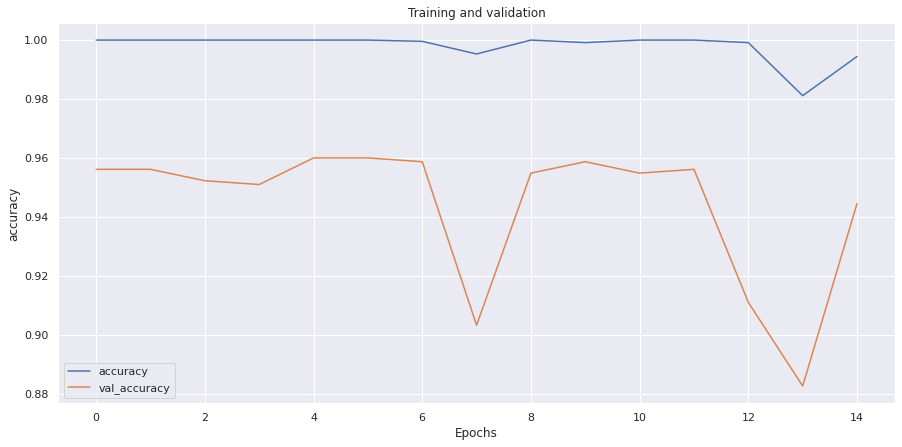

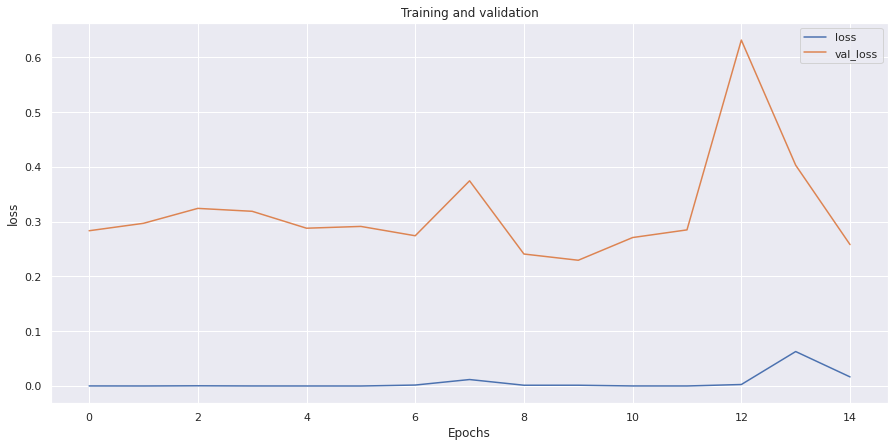

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_irnv2.save("irnv2.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
irnv2_model = load_model('irnv2.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = irnv2_model.evaluate(test_batches_irnv2, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 21s 512ms/step - loss: 0.3946 - accuracy: 0.9161
test loss: 0.39457976818084717
test acc: 0.9161290526390076


Compared to our other pretrained models, not only is the accuracy high for training, validation, and test sets but the accuracy is fairly consistent epoch to epoch. This is a very promising model that we'll tune in the next phase of the project. Though, overfitting will have to be addressed.

###InceptionV3

Lastly, we'll add one more last edition to the notebook - InceptionV3.

In [ ]:
iv3im = tf.keras.applications.InceptionV3(
                  include_top=False,
                  input_shape=(224, 224, 3))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
#Adjust several layers
model_iv3im = tf.keras.Sequential()
model_iv3im.add(iv3im)
model_iv3im.add(tf.keras.layers.Flatten())
model_iv3im.add(tf.keras.layers.Dense(256, activation='relu'))
model_iv3im.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_iv3im.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='iv3im.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model_iv3im.fit(train_batches, 
                    steps_per_epoch=73, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=25, 
                    epochs=15, 
                    verbose = 1)

Epoch 1/15
73/73 [==============================] - 2273s 31s/step - loss: 5.2177 - accuracy: 0.6615 - val_loss: 6314.7964 - val_accuracy: 0.3634

Epoch 00001: val_loss improved from inf to 6314.79639, saving model to iv3im.h5
Epoch 2/15
73/73 [==============================] - 47s 645ms/step - loss: 0.1643 - accuracy: 0.9485 - val_loss: 0.4742 - val_accuracy: 0.9227

Epoch 00002: val_loss improved from 6314.79639 to 0.47425, saving model to iv3im.h5
Epoch 3/15
73/73 [==============================] - 46s 632ms/step - loss: 0.0855 - accuracy: 0.9745 - val_loss: 0.4056 - val_accuracy: 0.9240

Epoch 00003: val_loss improved from 0.47425 to 0.40561, saving model to iv3im.h5
Epoch 4/15
73/73 [==============================] - 47s 644ms/step - loss: 0.0873 - accuracy: 0.9744 - val_loss: 0.8334 - val_accuracy: 0.7680

Epoch 00004: val_loss did not improve from 0.40561
Epoch 5/15
73/73 [==============================] - 46s 633ms/step - loss: 0.0556 - accuracy: 0.9816 - val_loss: 0.2679 - val

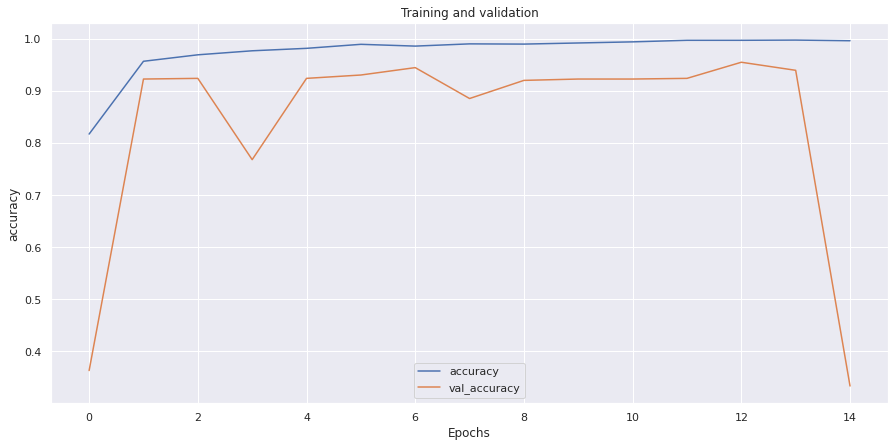

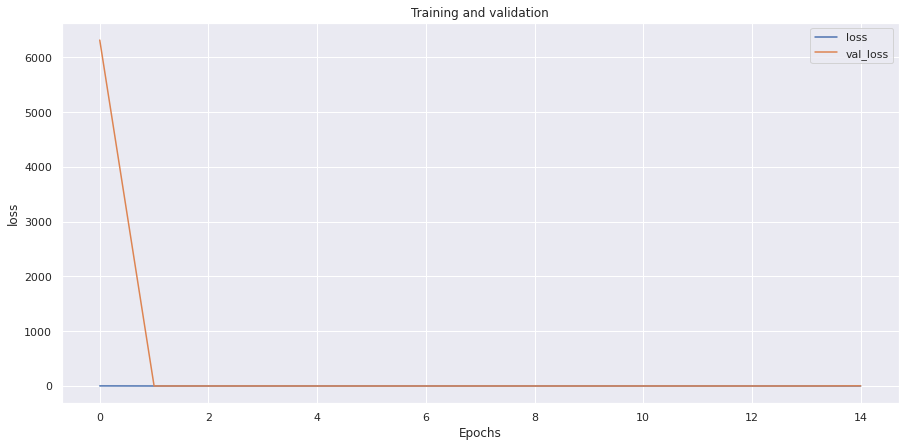

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_iv3im.save("iv3im.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
iv3im_model = load_model('iv3im.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = iv3im_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 569s 24s/step - loss: 0.3521 - accuracy: 0.9200
test loss: 0.35213562846183777
test acc: 0.9200000166893005


This model was our highest performer, so we'll also keep it for the next phase. 

Moving onto the next phase of this project, we'll tune our remaining models - our inital model, InceptionV3, and InceptionResnetV2.